In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


import nltk 
nltk.download('stopwords') 

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 



from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder


import re 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv',encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.drop([1, 2, 3, 4], axis=1,inplace=True)

In [4]:
df.columns = ['sentiment', 'twet_text']
df.head()

,sentiment,twet_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Text(0.5, 1.0, 'Sentiment Data Distribution')

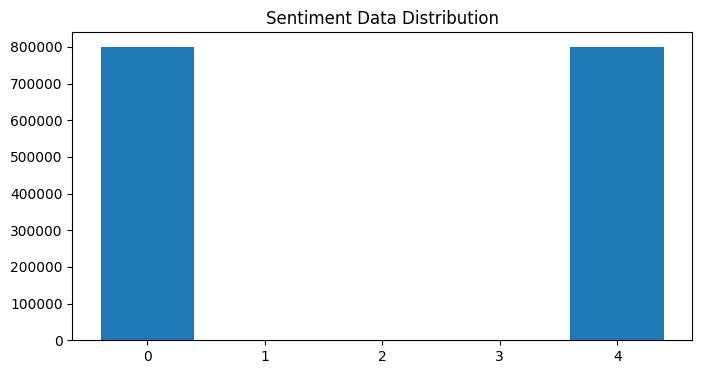

In [5]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [6]:
lab_to_sentiment = {0:0,1:1 ,4:1}

def label_decoder(label):
    return lab_to_sentiment[label]
df['sentiment'] = df['sentiment'].map(label_decoder)


In [7]:
df.sample(n=10)  

,sentiment,twet_text
465229,0,"@emcomm1 Hate to cut this short, but I have to..."
1164536,1,Yey got sorted on hexrpg at last. I'm in Slyt...
193526,0,"I'm pissed off, it's sad that no one understan..."
851399,1,Just joined twitter to see what all the fuss i...
1390671,1,"this is so awesome, im twittering from tweetde..."
588922,0,@_Mom24 My baby is 3.5 months old and I have b...
563830,0,At work
473752,0,@TinchenFFM stress scheiss montag
601093,0,I don't wanna reach the time when Gloria alrea...
789774,0,life gets complicated as u grow...


# Text Preprocessing

In [8]:
stop_words = stopwords.words('english') 
stemmer = SnowballStemmer('english') 

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+" 

In [9]:
def preprocess(text):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()

    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(token)
    return " ".join(tokens)  

In [10]:
df['twet_text'] = df['twet_text'].map(preprocess)

## Train and Test Split

In [11]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 3

In [12]:
train_data, test_data = train_test_split(df, test_size=0.2,random_state=7) 
                                                        
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


In [13]:
train_data.head(10)

,sentiment,twet_text
23786,0,need friends
182699,0,im trying call impossible
476661,0,good pace going 3k 13 min missed 5k turn ended...
1181490,1,u gonna shows ny soon luv see u live
878773,1,hell yea get em tattoos ink free wish parents ...
130866,0,yeah need 2 see ur mom calls back first rememb...
1235876,1,sounds like cup tea sign
717314,0,tired want sleep wtf
969880,1,amazing wish
748698,0,thank god wkrn abc affiliate nashville back mi...


In [14]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.twet_text) 

word_index = tokenizer.word_index  
vocab_size = len(tokenizer.word_index) + 1

print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


In [15]:
y_train=train_data['sentiment']
y_test=test_data['sentiment']

In [16]:
y_train=np.array(y_train)
y_test=np.array(y_test)

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.twet_text),
                        maxlen = 35)

x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.twet_text),
                       maxlen = 35)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 35)
Testing X Shape: (320000, 35)


In [18]:
GLOVE_EMB = r"glove.6B.300d.txt"
EMBEDDING_DIM = 300
LR = 1e-3 
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [19]:
embeddings_index = {}   

f = open(GLOVE_EMB,encoding="utf-8")
for line in f:
    values = line.split() 
    word = value = values[0] 
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400001 word vectors.


In [20]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [21]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

# Model Training

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, Activation, Dropout, MaxPooling1D, Concatenate, Dense, GlobalMaxPooling1D, Softmax
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
from keras.layers import concatenate

In [23]:
gpu=tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0],True)

In [37]:
def moel():
    
    inputs = Input(shape=(35,))
    
    
    embedding_dim = 128  
    embedded = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
    
   
    conv1 = Conv1D(filters=64, kernel_size=3, padding='valid')(embedded)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(0.5)(conv1)
   

   
    conv2 = Conv1D(filters=64, kernel_size=3, padding='valid')(embedded)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(0.5)(conv2)
   


    concatenated =concatenate([conv1, conv2])

 
    fc_units = 128  
    fc = Dense(units=fc_units)(concatenated)
    fc = GlobalMaxPooling1D()(fc)

   
    num_classes = 1  
    output = Dense(units=num_classes, activation='sigmoid')(fc)

    model = Model(inputs=inputs, outputs=output)

   
    optimizer = Adam(learning_rate=0.001)  
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [38]:
model=moel()

In [40]:
# Train the model with the entire training set
history=model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
40000/40000 [==============================] - 1501s 38ms/step - loss: 0.4653 - accuracy: 0.7787 - val_loss: 0.4786 - val_accuracy: 0.7801
Epoch 2/3
40000/40000 [==============================] - 1532s 38ms/step - loss: 0.4252 - accuracy: 0.8046 - val_loss: 0.5218 - val_accuracy: 0.7552
Epoch 3/3
40000/40000 [==============================] - 1342s 34ms/step - loss: 0.3923 - accuracy: 0.8235 - val_loss: 0.5149 - val_accuracy: 0.7635


In [ ]:
model=tf.keras.model.load_model("")

# Model Evaluation

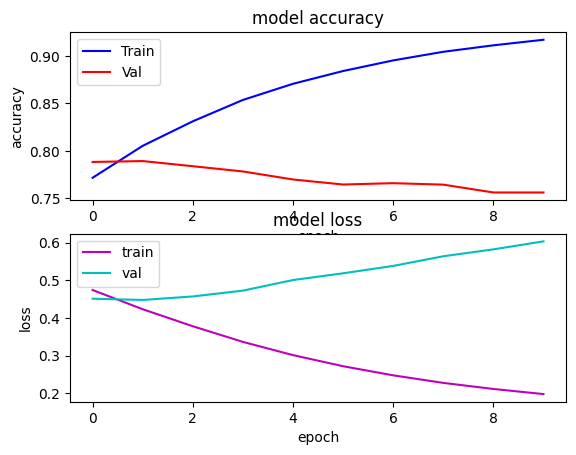

In [ ]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['Train', 'Val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [42]:
def decode_sentiment(score):
    return 1 if score>0.5 else 0

scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 14s 445ms/step


### Confusion Matrix

In [43]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
 

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

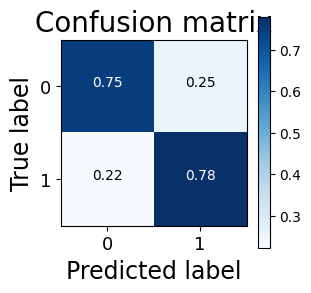

In [44]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(3,3))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()